In [39]:
from app.glance import Corpus, glance_at
from transformers import GPT2Tokenizer
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import json

In [40]:
c = Corpus('data/aesop-2048')
attention_mask, _, acts = c.load_all_data()
pile = Corpus('data/2048-pile10k')

acts = acts * attention_mask
acts = acts[:, :514, :]
attention_mask = attention_mask[:, :514, :]
normalized_acts = acts / (torch.amax(acts, dim=(0, 1)) + 1e-8)

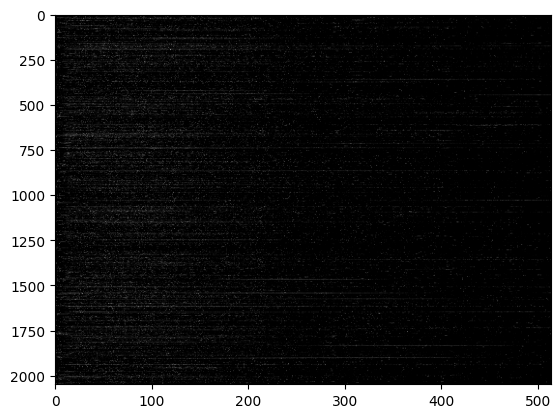

In [42]:
plt.imshow(torch.max(normalized_acts, dim=0)[0].T, cmap='gray', aspect='auto')

In [43]:
def stretch_activations(activations, attention_mask):
    n_samples, seq_len, n_features = activations.shape
    max_len = attention_mask.sum(dim=1).max().item()  # Get the maximum non-padded length

    stretched_activations = torch.zeros((n_samples, max_len, n_features), device=activations.device)
    
    for i in range(n_samples):
        non_padded_len = attention_mask[i].sum().item()  # Find the actual length of each sequence
        if non_padded_len == 0:
            continue

        # Get the sequence without padding
        seq = activations[i, :non_padded_len].unsqueeze(0).permute(0, 2, 1)  # Shape: 1 x n_features x non_padded_len

        # Interpolate the sequence
        stretched_seq = F.interpolate(seq, size=(max_len,), mode='linear', align_corners=False)

        stretched_activations[i] = stretched_seq.squeeze(0).permute(1, 0)  # Shape: max_len x n_features
    
    return stretched_activations

In [44]:
s = stretch_activations(normalized_acts, attention_mask.to(torch.int))

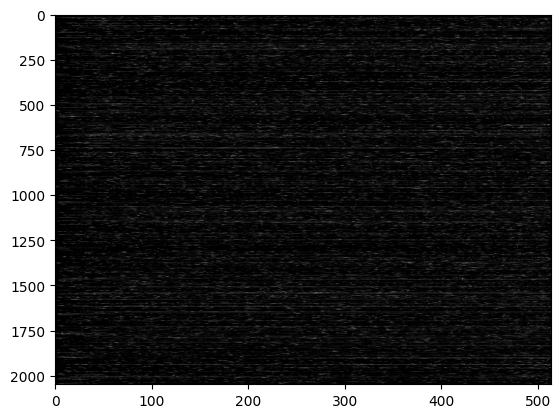

In [45]:
plt.imshow(torch.max(s, dim=0)[0].T, cmap='gray', aspect='auto')

In [48]:
delta = (c.stats['max_activations'][0] - pile.stats['max_activations'][0]) / c.stats['max_activations'][0]

topk_values, topk_indices = torch.topk(delta, 24)

In [49]:
with open('cruft/pile10k-2048.json') as f:
    pile10k = json.load(f)

In [50]:
top_fts = []
explain = []
for i in topk_indices:
    for f in pile10k:
        if f['feature'] == i:
            top_fts.append(str(i.item()) + " " + f['assessment']['feature_name'])
            explain.append(f['assessment']['feature_description'])

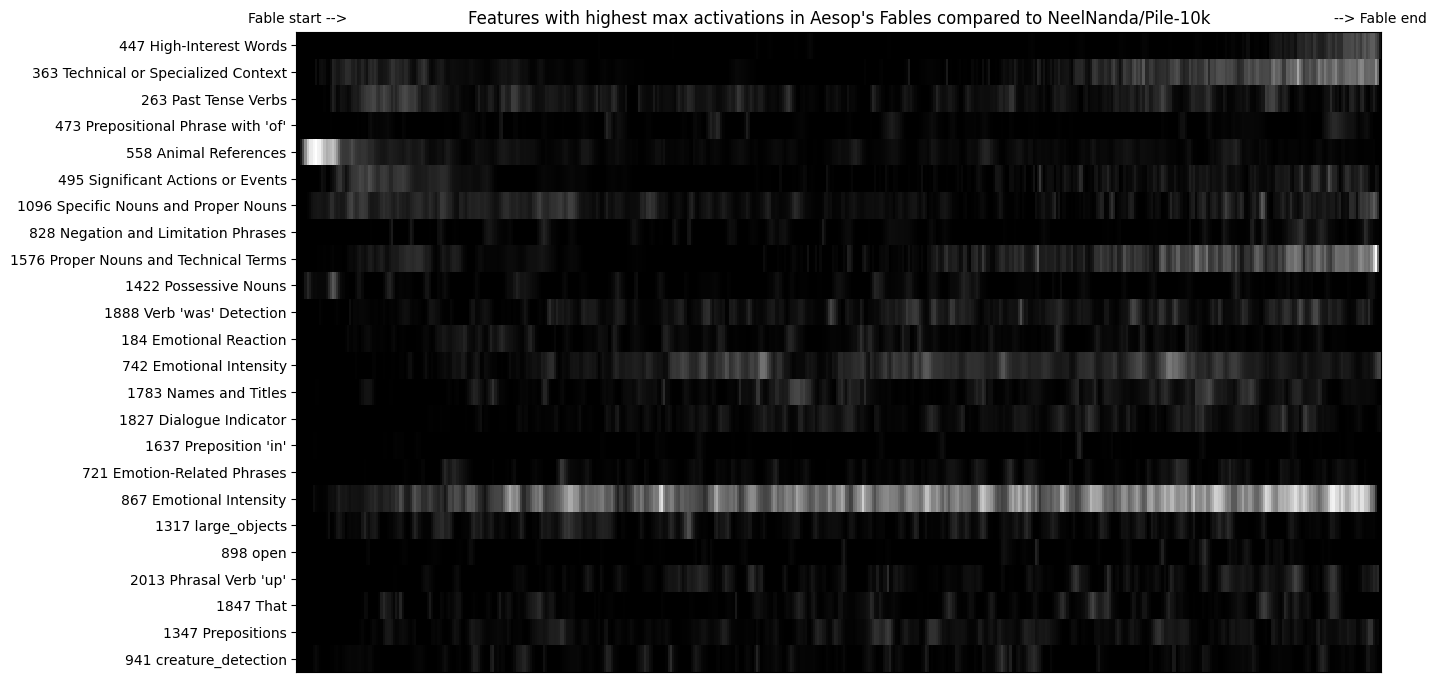

In [55]:
toplot = torch.mean(s[:, :, topk_indices], dim=0).T
# toplot = torch.max(s[:, :, topk_indices], dim=0)[0].T


plt.figure(figsize=(14, 8))

plt.imshow(toplot, cmap='gray', aspect='auto', interpolation="nearest")
plt.yticks(ticks=range(len(top_fts)), labels=top_fts)

plt.xticks([])
plt.title("Features with highest max activations in Aesop's Fables compared to NeelNanda/Pile-10k")
# Add "start" and "end" labels
plt.text(0, -1, 'Fable start -->', ha='center', va='center', fontsize=10, color='black')
plt.text(toplot.shape[1] - 1, -1,  '--> Fable end', ha='center', va='center', fontsize=10, color='black')

plt.subplots_adjust(top=0.95, bottom=0.15)
# Show the plot
plt.show()

In [52]:
w = c.by_relative_idx(topk_indices)

Loading samples from disk: 100%|██████████| 128/128 [00:02<00:00, 49.00it/s]


In [53]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [54]:
for i, feature in enumerate(w):
    print('---------', top_fts[i], '---------')
    print(explain[i])
    
    for tokens, token_acts in feature['samples']:
        try:
            glance_at(tokens, token_acts, tokenizer)
        except:
            continue

--------- 447 High-Interest Words ---------
The model detects words that are likely to be of high interest or importance in the context, such as company names, key terms, and emotionally charged words.
ailed and called on Mercury to help them . And 
And indeed , Mercury did appear , first to this one , then 
, then to that . To each one he showed an axe of gold , and each one eagerly claimed it to be the one he had lost . But Mercury did not give them the golden axe . Oh no ! Instead he gave them each a hard wh ack over the head with it and sent them home . And when they returned next day to look for their own axes , they were nowhere to be found . 
to do it , I admit - A great uproar among the beasts interrupted 
him . Here was the culprit who had brought misfortune on all of them 
of them ! What a horrible crime it was to eat grass that 
to someone else ! It was enough to hang anyone for , much more an Ass . Immediately they all fell upon him , the Wolf in the lead , and soon had mad